<a href="https://colab.research.google.com/github/xDevICCI/TallerDeepLearning/blob/main/VictorGodoy_XXXXXXXXX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='red'>WARNING-1: No se aceptan soluciones que usen metodologías distintas a las vistas en clases.</font>

<font color='orange'>Está permitido usar los códigos de los ejemplos vistos en clases.</font>



# 0) Cambiar el nombre del archivo

<font color='red'>WARNING-2: CAMBIA EL NOMBRE DEL ARCHIVO ipynb INCLUYENDO TU NOMBRE Y RUT</font>

Ejemplo, si tu nombres es Pedro Perez y RUT es 12.345.678-9, el nombre de este archivo debe cambiarse de "Nombre_Rut.ipynb" a "Pedro_Perez_12345678-9.ipynb"


🏷️ Nombre del proyecto:
# Predicción de Fallas y Retrasos en Manufactura con LSTM

# 📊 Descripción del dataset y problema a resolver:

Este proyecto aborda un problema de clasificación multiclase en un entorno de manufactura híbrida. A partir de un conjunto de datos que contiene información de trabajos asignados a distintas máquinas (incluyendo tipo de operación, material utilizado, tiempos programados y reales, consumo energético y estado final del trabajo), se busca predecir el campo Job_Status, que puede tomar los siguientes valores:

- Completed: el trabajo se ejecutó correctamente dentro del rango esperado.
- Delayed: el trabajo se ejecutó pero con retrasos respecto al plan.
- Failed: el trabajo no se completó o tuvo problemas críticos.

La solución se implementará utilizando modelos de Deep Learning como redes LSTM o Multilayer Perceptrons (MLP) para identificar patrones en los datos que permitan anticipar fallos y retrasos antes de que ocurran.

# 1) Carga de datos y librerías a utilizar

(2 puntos)

Incluya aquí todas las librerías a utilizar en este código.

De una ubicación de los datos para ser descargados.

Por ejemplo: Los datos se encuentran en `https://www.dropbox.com/s/p94odo87ekacd46/bikes3.zip`




In [ ]:
!pip install tensorflow

In [1]:
# 1.1 Versiones fijas para reproducibilidad
#!pip install -q numpy==1.26.4 pandas==2.2.2 scikit-learn==1.4.2 imbalanced-learn==0.12.2 \
#             matplotlib==3.9.0 seaborn==0.13.2 tensorflow==2.16.1 keras==3.3.3 shap==0.45.1

# 1.2 Imports centrales
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import shap, warnings, tensorflow as tf
warnings.filterwarnings("ignore")

# 1.3 Semilla única para reproducir todo
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


# Carga de datos
df = pd.read_csv("sample_data/hybrid_manufacturing_categorical.csv")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2) Definición de parámetros

(1 punto)

Defina los parámetros necesarios. Por ejemplo: `fpath` (path de los archivos), `BATCH_SIZE`, etc.



In [2]:
# Ruta del archivo
fpath = "sample_data/hybrid_manufacturing_categorical.csv"

# Parámetros del modelo
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
SEED = 42
TEST_SIZE = 0.2


In [30]:
df.count()

,0
Job_ID,871
Machine_ID,871
Operation_Type,871
Material_Used,871
Processing_Time,871
Energy_Consumption,871
Machine_Availability,871
Scheduled_Start,871
Scheduled_End,871
Actual_Start,871


# 3) Pre-procesamiento y Data augmentation (si es necesario, investigue métodos para el aumento de los datos artificialente)

(2 puntos)

Defina los parámetros necesarios, haga los cambios necesarios considerando el tamaño de las imágenes, señales, etc.



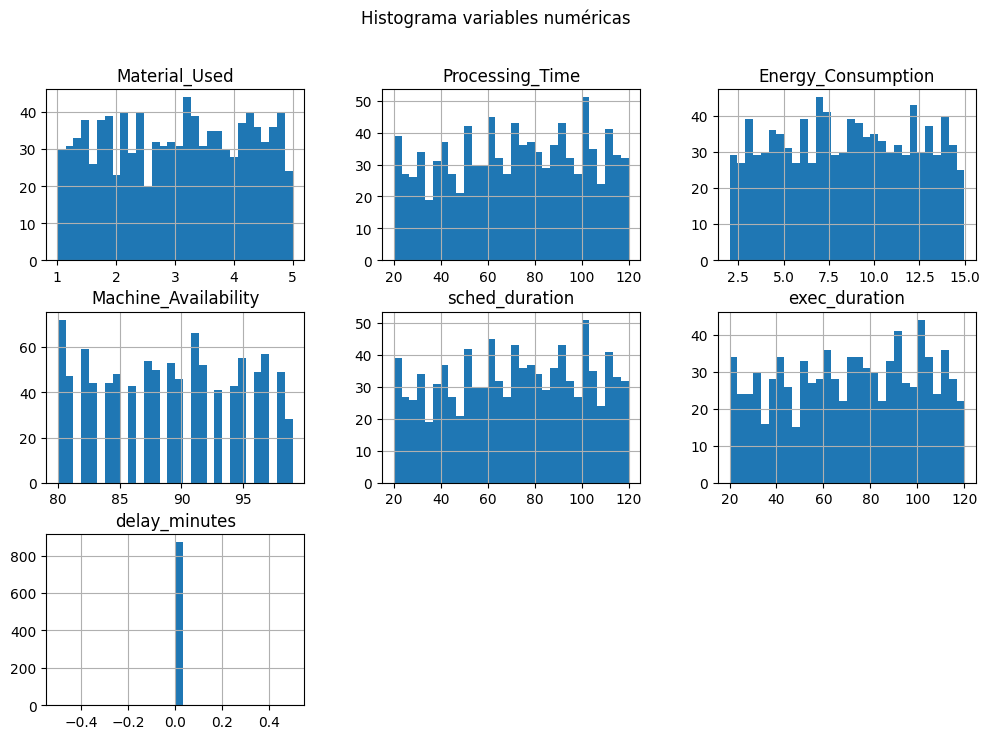

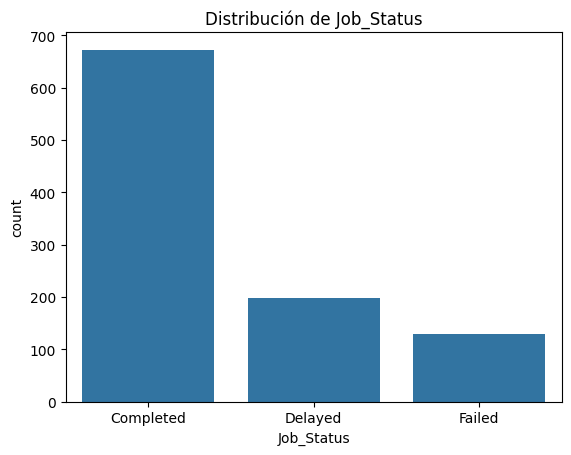

In [3]:
# 3.2 Conversiones de fecha a duraciones (evitamos colinealidad)
date_cols = ["Scheduled_Start","Scheduled_End","Actual_Start","Actual_End"]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")
df["sched_duration"] = (df["Scheduled_End"] - df["Scheduled_Start"]).dt.total_seconds()/60
df["exec_duration"]  = (df["Actual_End"]    - df["Actual_Start"   ]).dt.total_seconds()/60
df["delay_minutes"]  = df["exec_duration"] - df["sched_duration"]
df = df.drop(columns=date_cols)

# 3.3 Distribuciones numéricas
num_cols = df.select_dtypes("number").columns
df[num_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("Histograma variables numéricas"); plt.show()

# 3.4 Recuento de clases
sns.countplot(x=df["Job_Status"])
plt.title("Distribución de Job_Status"); plt.show()

In [4]:
# Eliminamos filas con datos faltantes.
df = df.dropna()


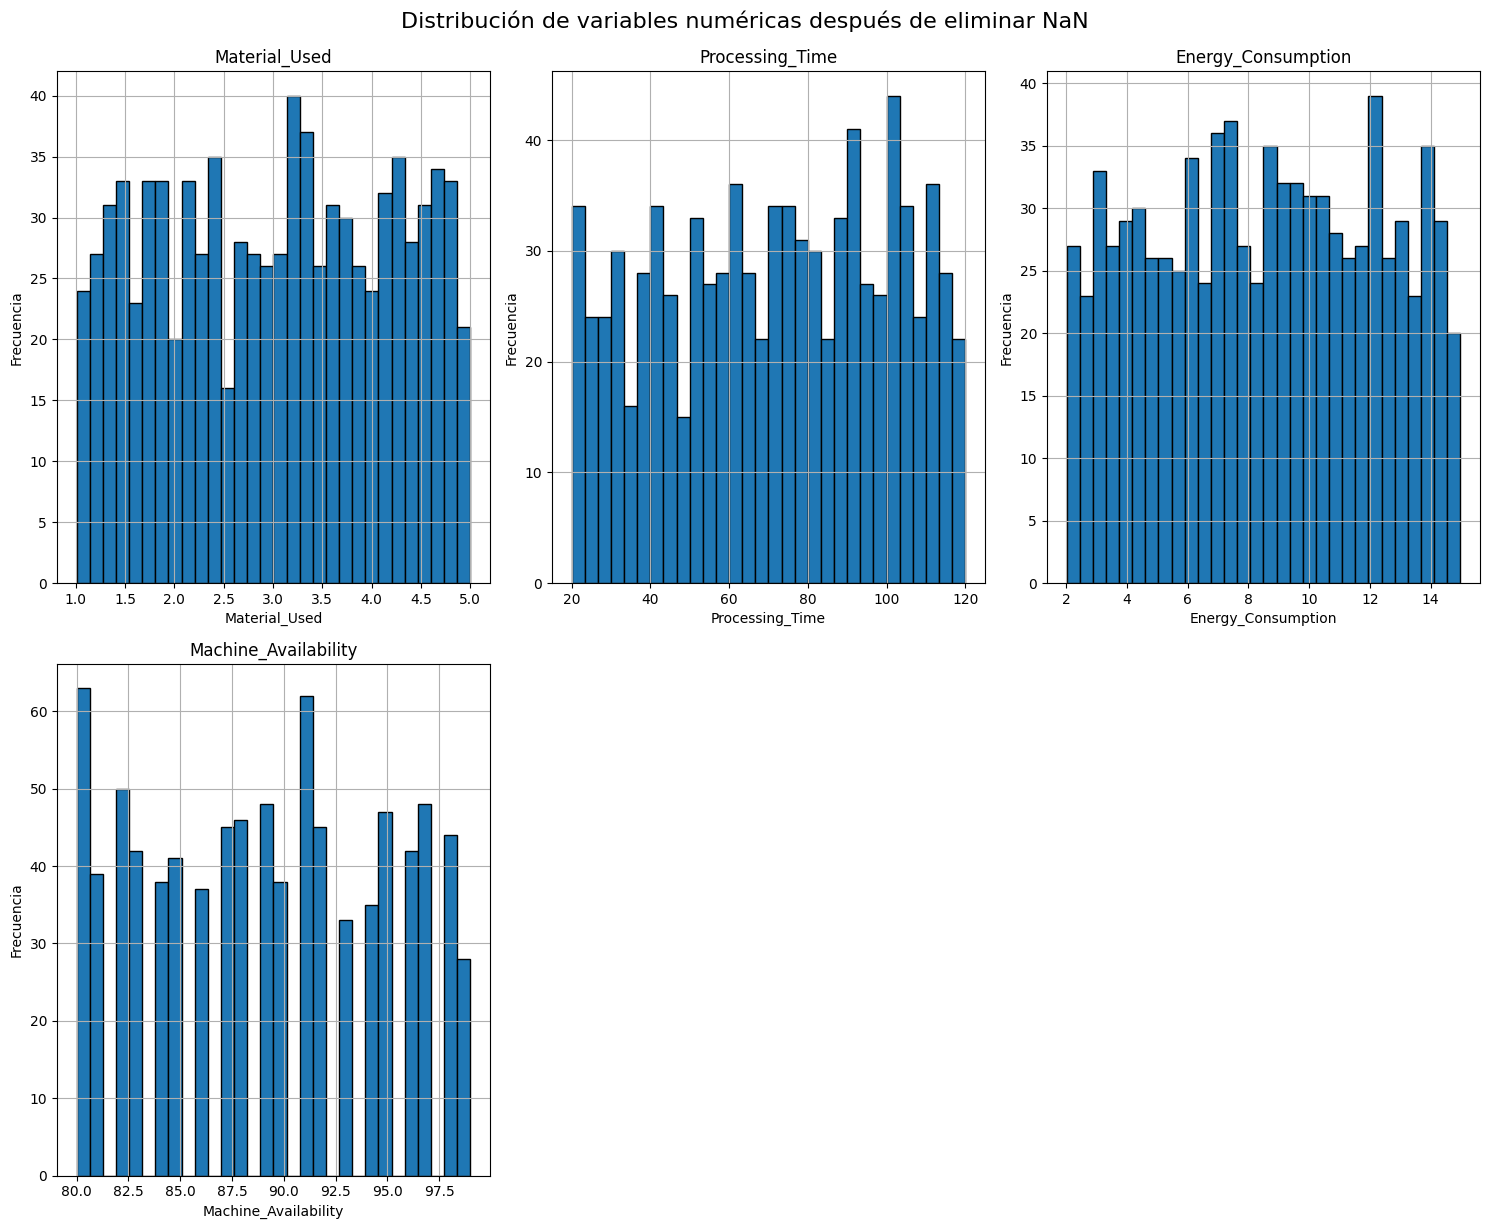

In [5]:
# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Crear histogramas
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) + 2) // 3, 3, i + 1)
    df[col].hist(bins=30, edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Distribución de variables numéricas después de eliminar NaN", fontsize=16, y=1.02)
plt.show()

<ipython-input-6-315cf34cd31b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Job_Status', order=df['Job_Status'].value_counts().index, palette='pastel')


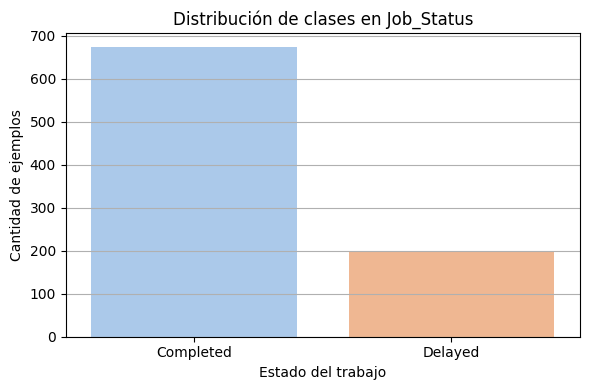

In [6]:
# Visualizar distribución de clases en Job_Status
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Job_Status', order=df['Job_Status'].value_counts().index, palette='pastel')
plt.title("Distribución de clases en Job_Status")
plt.xlabel("Estado del trabajo")
plt.ylabel("Cantidad de ejemplos")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# 4.4 - Split normal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

# ✅ 4.4.1 - Reservar 20 ejemplos por clase del train
df_train = X_train.copy()
df_train["Job_Status"] = y_train

df_holdout = pd.concat([
    df_train[df_train["Job_Status"] == c].sample(n=20, random_state=SEED)
    for c in df_train["Job_Status"].unique()
])

# El resto se usa para entrenar
df_train_final = df_train.drop(df_holdout.index)

# Separar X/y finales
X_train = df_train_final.drop(columns="Job_Status")
y_train = df_train_final["Job_Status"]

# Holdout set para evaluar overfitting real
X_holdout = df_holdout.drop(columns="Job_Status")
y_holdout = df_holdout["Job_Status"]


SACAR 20 DATOS DE CADA CLASES (ANTES DE APLICAR SMOTE) - PARA SABER SI REALIZA OVERFITTING

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
# 4.1 Separación X / y
y = df["Job_Status"]
X = df.drop(columns=["Job_ID", "Job_Status"])  # elimina ID que no aporta

# 4.2 Columnas categóricas y numéricas
cat_cols = ["Machine_ID", "Operation_Type", "Optimization_Category"]
num_cols = [c for c in X.columns if c not in cat_cols]

# 4.3 Pipelines con imputación + escalado/codificación
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler" , StandardScaler())
])

pre = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
], remainder="drop")

# 4.4 Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

# 4.5 Transformar datos (con imputación incluida)
X_train_proc = pre.fit_transform(X_train)
X_test_proc  = pre.transform(X_test)

# Verificación estricta
assert not np.isnan(X_train_proc).any(), "❌ NaN en X_train_proc"
assert not np.isnan(X_test_proc ).any(), "❌ NaN en X_test_proc"

# 4.6 Aplicar SMOTE solo sobre train
smote = SMOTE(random_state=SEED)
X_train_sm, y_train_sm = smote.fit_resample(X_train_proc, y_train)

# 4.7 Confirmación
print("✔️  Preprocesamiento completo")
print("Tamaño antes SMOTE:", X_train.shape)
print("Tamaño después SMOTE:", X_train_sm.shape)
print("Distribución tras SMOTE:\n", pd.Series(y_train_sm).value_counts())



✔️  Preprocesamiento completo
Tamaño antes SMOTE: (800, 10)
Tamaño después SMOTE: (1617, 21)
Distribución tras SMOTE:
 Job_Status
Completed    539
Failed       539
Delayed      539
Name: count, dtype: int64


VERIFICAR Y VALIDAR EL USO DEL SMOTE

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical

# Convertimos las columnas categóricas
label_cols = ['Machine_ID', 'Operation_Type', 'Optimization_Category']
df[label_cols] = df[label_cols].astype(str)

for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Convertimos fechas a minutos desde el inicio
for col in ['Scheduled_Start', 'Scheduled_End', 'Actual_Start', 'Actual_End']:
    df[col] = pd.to_datetime(df[col])
    df[col] = (df[col] - df[col].min()).dt.total_seconds() / 60  # en minutos

# Definimos X (features) e y (target)
X = df.drop(columns=['Job_ID', 'Job_Status'])
y = df['Job_Status']

# Codificamos y en enteros
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# Normalizamos X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicamos SMOTE antes de dividir en train/test
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# Convertimos y a one-hot para Keras
y_resampled_cat = to_categorical(y_resampled)

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled_cat, test_size=TEST_SIZE, random_state=SEED, stratify=y_resampled_cat)


[0 1 0 ... 1 1 1]


(array([673.,   0., 673.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

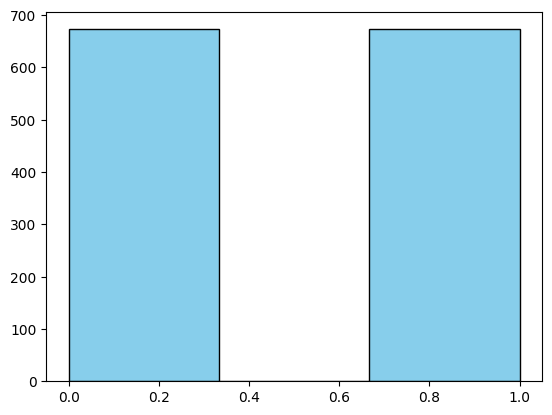

In [29]:
print(y_resampled)

plt.hist(y_resampled, bins=3, color='skyblue', edgecolor='black')

# 4) Definir el modelo

(1 punto)

Defina la clase donde se decriba y declare el o los modelos a usar.



In [11]:
def build_mlp(input_dim, n_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(), Dropout(0.30),
        Dense(64,  activation='relu'),
        BatchNormalization(), Dropout(0.20),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

# 5) Entrenar el modelo

(4 puntos)

Entre el modelo definido en los pasos anteriores

In [12]:
def train_variant(X_tr, y_tr, X_te, y_te, class_w=None, tag="VAR"):
    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
    ck = ModelCheckpoint(f"best_{tag}.keras", monitor='val_loss',
                         save_best_only=True, verbose=0)
    model = build_mlp(X_tr.shape[1], len(np.unique(y)))
    hist  = model.fit(X_tr, y_tr, validation_split=0.2,
                      epochs=100, batch_size=32,
                      callbacks=[es, ck],
                      class_weight=class_w,
                      verbose=0)
    print(f"‑‑‑‑‑ Evaluación {tag} ‑‑‑‑‑")
    y_pred = model.predict(X_te).argmax(axis=1)
    print(classification_report(y_te, y_pred, target_names=np.unique(y)))
    return model, hist

# 6.1 Baseline
le = LabelEncoder(); y_train_int = le.fit_transform(y_train); y_test_int = le.transform(y_test)
baseline_model, h0 = train_variant(X_train_proc, y_train_int, X_test_proc, y_test_int, tag="BASE")

# 6.2 SMOTE
y_train_sm_int = le.transform(y_train_sm)
smote_model, h1 = train_variant(X_train_sm, y_train_sm_int, X_test_proc, y_test_int, tag="SMOTE")

# 6.3 class_weight
cw = compute_class_weight(class_weight="balanced",
                          classes=np.unique(y_train_int),
                          y=y_train_int)
cw_dict = {i: w for i, w in enumerate(cw)}
cw_model, h2 = train_variant(X_train_proc, y_train_int, X_test_proc, y_test_int,
                             class_w=cw_dict, tag="CWEIGHT")


‑‑‑‑‑ Evaluación BASE ‑‑‑‑‑
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
              precision    recall  f1-score   support

   Completed       0.73      0.88      0.80       134
     Delayed       0.14      0.07      0.10        40
      Failed       1.00      0.65      0.79        26

    accuracy                           0.69       200
   macro avg       0.62      0.54      0.56       200
weighted avg       0.65      0.69      0.66       200

‑‑‑‑‑ Evaluación SMOTE ‑‑‑‑‑
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
              precision    recall  f1-score   support

   Completed       0.78      0.75      0.76       134
     Delayed       0.27      0.35      0.31        40
      Failed       0.95      0.77      0.85        26

    accuracy                           0.67       200
   macro avg       0.67      0.62      0.64       200
weighted avg       0.70      0.67      0.68       200

‑‑‑‑‑ Evaluación CWEIGHT ‑‑‑‑‑


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
              precision    recall  f1-score   support

   Completed       0.87      0.69      0.77       134
     Delayed       0.37      0.60      0.46        40
      Failed       0.72      0.81      0.76        26

    accuracy                           0.69       200
   macro avg       0.65      0.70      0.66       200
weighted avg       0.75      0.69      0.70       200



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


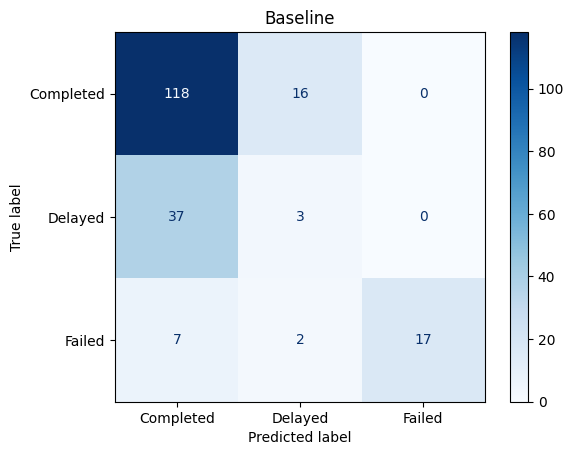

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


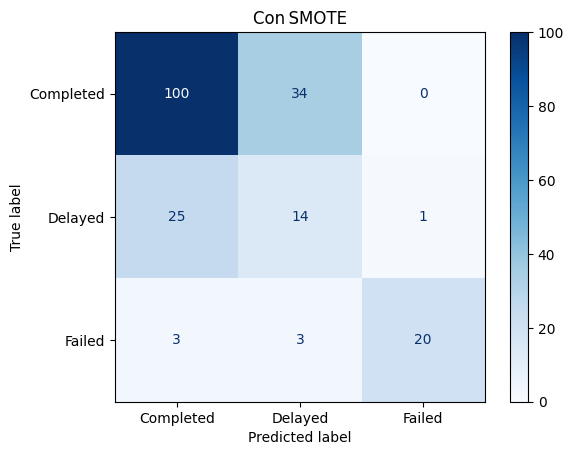

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


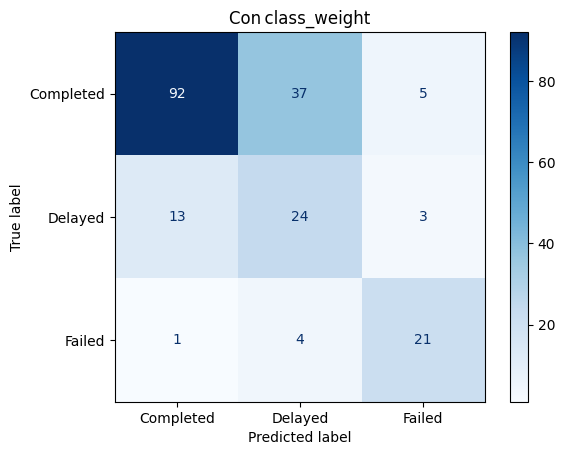

In [13]:
def plot_cm(model, X_te, y_te, title):
    y_pred = model.predict(X_te).argmax(axis=1)
    cm = confusion_matrix(y_te, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(cmap="Blues")
    plt.title(title); plt.show()

plot_cm(baseline_model, X_test_proc, y_test_int, "Baseline")
plot_cm(smote_model   , X_test_proc, y_test_int, "Con SMOTE")
plot_cm(cw_model      , X_test_proc, y_test_int, "Con class_weight")


# VALIDACIÓN Y VER PROGRESO DE MEJORA AL MEJORAR EL DESBALANCE

# 6) Evaluación de desempeño

(2 puntos)

Calcule el accuracy en el training, validation y testing.

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 6.1 - Evaluación en entrenamiento
y_train_pred = smote_model.predict(X_train_sm).argmax(axis=1)
train_acc = accuracy_score(y_train_sm, y_train_pred)

# 6.2 - Evaluación en validación (se obtuvo durante entrenamiento con val_split=0.2)
val_acc = max(h1.history['val_accuracy'])  # si usaste h1 = model.fit(...)

# 6.3 - Evaluación en test
y_test_pred = smote_model.predict(X_test_proc).argmax(axis=1)
y_test_int = LabelEncoder().fit(y).transform(y_test)
test_acc = accuracy_score(y_test_int, y_test_pred)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


# 7) Evaluación aleatoria (de una imagen, señal etc.) del testing

(1 punto)

Despliegue una señal, imagen, cadena de texto, etc.,  aleatoria del testing con la clasificación proporcionada por el Transformer entrenado.

📊 Accuracy del modelo SMOTE:
✔️  Entrenamiento: 0.0000
✔️  Validación   : 0.9969
✔️  Test final   : 0.6700

🔍 Reporte de clasificación (test set):
              precision    recall  f1-score   support

   Completed       0.78      0.75      0.76       134
     Delayed       0.27      0.35      0.31        40
      Failed       0.95      0.77      0.85        26

    accuracy                           0.67       200
   macro avg       0.67      0.62      0.64       200
weighted avg       0.70      0.67      0.68       200



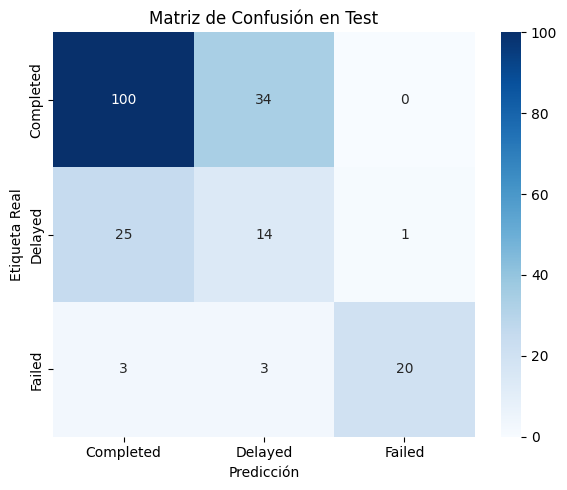

In [16]:

# 6.4 - Mostrar resultados
print("📊 Accuracy del modelo SMOTE:")
print(f"✔️  Entrenamiento: {train_acc:.4f}")
print(f"✔️  Validación   : {val_acc:.4f}")
print(f"✔️  Test final   : {test_acc:.4f}")

# 6.5 - Reporte completo
print("\n🔍 Reporte de clasificación (test set):")
print(classification_report(y_test_int, y_test_pred, target_names=np.unique(y)))

# 6.6 - Matriz de confusión
cm = confusion_matrix(y_test_int, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicción"); plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión en Test"); plt.tight_layout(); plt.show()
